# Imports

In [1]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import librosa
import datetime


# Load Data

In [2]:
sub_files = glob('../*/*.xdf')
sub_files

['../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [ ]:
xdf_path = sub_files[0]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
# get rows of df in between time stamps corresponding to event_onset and event_offset
# get df data within event 
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['WebcamStream',
 'Tobii',
 'Stimuli_Markers',
 'OpenSignals',
 'EGI NetAmp 0',
 'Microphone']

# Stimulus

In [4]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_Experiment,737702.874688,0.000000e+00
1,1729193598,psychopy_time_stamp,737702.874699,1.029996e-08
2,10,Onset_RestingState,737715.257669,1.238298e-02
3,1729193610,psychopy_time_stamp,737715.257678,1.238299e-02
4,11,Offset_RestingState,738015.257488,3.123828e-01
...,...,...,...,...
256,1729195883,psychopy_time_stamp,739988.698994,2.285824e+00
257,201,Offset_Experiment,739993.702234,2.290828e+00
258,1729195888,psychopy_time_stamp,739993.702247,2.290828e+00
259,4,Bx_input,739993.702478,2.290828e+00


# Microphone Data 

In [5]:
mic_data = data[streams_collected.index('Microphone')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
mic_df['time_stamps'] = (mic_data['time_stamps'] - mic_data['time_stamps'][0])/441000

mic_df['lsl_time_stamp'] = mic_data['time_stamps']
mic_df['time'] = (mic_df.lsl_time_stamp - mic_df.lsl_time_stamp[0])
mic_df['time_delta'] = mic_df['lsl_time_stamp'].diff()

mic_df.tail()

,int_array,bytestring,time_stamps,lsl_time_stamp,time,time_delta
87732536,31,b'\x1f\x00\x00\x00\x00\x00\x00\x00',0.004511,740040.097456,1989.483575,0.000023
87732537,30,b'\x1e\x00\x00\x00\x00\x00\x00\x00',0.004511,740040.097479,1989.483598,0.000023
87732538,26,b'\x1a\x00\x00\x00\x00\x00\x00\x00',0.004511,740040.097501,1989.483621,0.000023
87732539,26,b'\x1a\x00\x00\x00\x00\x00\x00\x00',0.004511,740040.097524,1989.483643,0.000023
87732540,-37,b'\xdb\xff\xff\xff\xff\xff\xff\xff',0.004511,740040.097547,1989.483666,0.000023


In [43]:
float(mic_data['info']['nominal_srate'][0])

44100.0

In [59]:
srate = mic_data['info']['effective_srate']

In [58]:
type(srate)

int

In [60]:
44100.00-srate

1.8545886341962614

In [62]:
mic_data

{'info': defaultdict(list,
             {'name': ['Microphone'],
              'type': ['AudioCapture'],
              'channel_count': ['1'],
              'channel_format': ['int16'],
              'source_id': ['audio-C4-BIOSIGNALS'],
              'nominal_srate': ['44100.00000000000'],
              'version': ['1.100000000000000'],
              'created_at': ['1903267.601001500'],
              'uid': ['336c2d7d-57d7-4d4c-976e-4fe2bd2d139a'],
              'session_id': ['default'],
              'hostname': ['C4-BIOSIGNALS'],
              'v4address': [None],
              'v4data_port': ['16573'],
              'v4service_port': ['16573'],
              'v6address': [None],
              'v6data_port': ['16573'],
              'v6service_port': ['16573'],
              'desc': [None],
              'stream_id': 3,
              'effective_srate': 44098.145411365804}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['1904873.067357976'],
              

## Compare wav and LSL lengths

In [6]:
# get wav file
wav_files = glob('../*/*.wav')
wav_files

wav_path = wav_files[0]
wav_path

'../sub-P5318014/sub-P5318014_task-CUNY_run-001_mic.wav'

In [7]:
# calculate wav and lsl durations
wav_dur = round(librosa.get_duration(path=wav_path), 2)
lsl_dur = round(mic_df['lsl_time_stamp'].iloc[-1]- mic_df['lsl_time_stamp'].iloc[0], 2)

# convert to hh:mm:ss
wav_dt = datetime.timedelta(seconds=wav_dur)
wav_dur_dt = str(datetime.timedelta(seconds=round(wav_dt.total_seconds())))
lsl_dt = datetime.timedelta(seconds=lsl_dur)
lsl_dur_dt = str(datetime.timedelta(seconds=round(lsl_dt.total_seconds())))


# make df of durations
variables = {name: [globals()[name], globals()[name+'_dt']]  for name in ['wav_dur', 'lsl_dur']}
durations_df = pd.DataFrame.from_dict(variables, orient = 'index', columns = ['seconds', 'mm:ss'])
print(durations_df.to_string() + '\n')

# print if they are close or not (margin on 5 seconds rn)
if abs(wav_dur - lsl_dur) > 5:
    print(f'Warning: The duration of the wav file ({wav_dur}) and the duration of the lsl time stamps ({lsl_dur}) differ by more than 5 seconds. \n')
    if wav_dur > lsl_dur:
        print('The wav file is longer than the lsl time stamps by {} seconds'.format(wav_dur - lsl_dur))
    if lsl_dur > wav_dur:
        print('The lsl time stamps are longer than the wav file by {} seconds'.format(lsl_dur - wav_dur))
else: 
    print('The wav file and the lsl time stamps are the same length!')

         seconds    mm:ss
wav_dur  1989.40  0:33:09
lsl_dur  1989.48  0:33:09

The wav file and the lsl time stamps are the same length!


## Slice parts we care about

In [8]:
slice_mic1 = mic_df.loc[(mic_df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_StoryListening', 'lsl_time_stamp'].values[0]) & 
                  (mic_df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Onset_impedanceCheck', 'lsl_time_stamp'].values[0])]
slice_mic2 = mic_df.loc[(mic_df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Offset_impedanceCheck', 'lsl_time_stamp'].values[0]) & 
                  (mic_df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0])]

slice_exp1 = stim_df.loc[(stim_df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_BirthdayParty', 'lsl_time_stamp'].values[0]) & 
                  (stim_df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Onset_impedanceCheck', 'lsl_time_stamp'].values[0])]
slice_exp2 = stim_df.loc[(stim_df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Offset_impedanceCheck', 'lsl_time_stamp'].values[0]) & 
                  (stim_df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0])]

## Compare experiment and mic durations with sliced data

In [9]:
slice_mic = mic_df.loc[(mic_df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_StoryListening', 'lsl_time_stamp'].values[0]) & 
                  (mic_df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0])]

slice_exp = stim_df.loc[(stim_df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_StoryListening', 'lsl_time_stamp'].values[0]) & 
                  (stim_df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0])]

In [10]:
mic_start = slice_mic['lsl_time_stamp'].values[0]
mic_stop = slice_mic['lsl_time_stamp'].values[-1]
mic_dur0 = round(mic_stop - mic_start, 4)
mic_dur0

1943.0883

In [11]:
exp_start = slice_exp['lsl_time_stamp'].values[0]
exp_stop = slice_exp['lsl_time_stamp'].values[-1]
exp_dur0 = round(exp_stop - exp_start, 4)
exp_dur0

1978.4447

In [12]:
mic_start1 = slice_mic1['lsl_time_stamp'].values[0]
mic_stop1 = slice_mic1['lsl_time_stamp'].values[-1]
mic_dur1 = round(mic_stop1 - mic_start1, 4)

mic_start2 = slice_mic2['lsl_time_stamp'].values[0]
mic_stop2 = slice_mic2['lsl_time_stamp'].values[-1]
mic_dur2 = round(mic_stop2 - mic_start2, 4)
mic_dur = mic_dur1 + mic_dur2
mic_dur

1655.2557000000002

In [13]:
mic_dur1

1337.0721

In [14]:
mic_dur2

318.1836

In [15]:
exp_start1 = slice_exp1['lsl_time_stamp'].values[0]
exp_stop1 = slice_exp1['lsl_time_stamp'].values[-1]
exp_dur1 = round(exp_stop1 - exp_start1, 4)

exp_start2 = slice_exp2['lsl_time_stamp'].values[0]
exp_stop2 = slice_exp2['lsl_time_stamp'].values[-1]
exp_dur2 = round(exp_stop2 - exp_start2, 4)
exp_dur = exp_dur1 + exp_dur2
exp_dur

1588.6033

In [16]:
exp_dur1

1270.4197

In [17]:
exp_dur2

318.1836

In [18]:
exp_start = slice_exp['lsl_time_stamp'].values[0]
exp_stop = slice_exp['lsl_time_stamp'].values[-1]
exp_dur = round(exp_stop - exp_start, 4)
exp_dur

1978.4447

## 

In [23]:
b'G\x00\x00\x00\x00\x00\x00\x00'.decode('utf-16')

'G\x00\x00\x00'

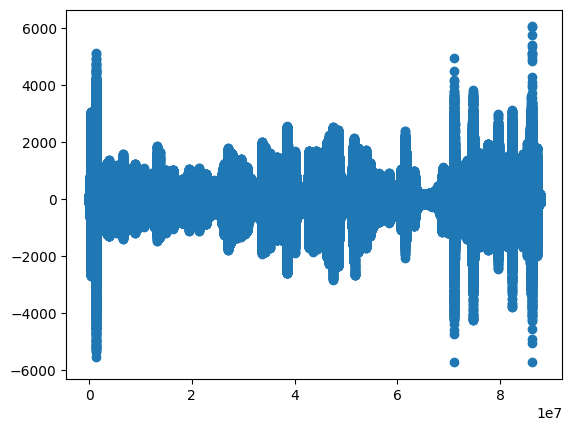

In [24]:
import matplotlib.pyplot as plt

plt.scatter(mic_df.index, mic_df['int_array'])
plt.show()

In [27]:
max(mic_df['int_array'])

6073

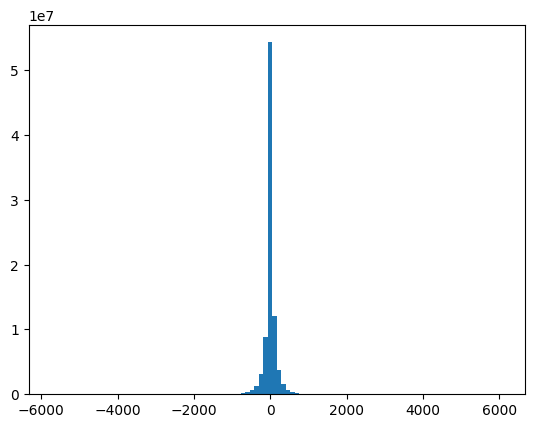

In [30]:
plt.hist(mic_df['int_array'], bins=100)
plt.show()

In [33]:
np.quantile(mic_df['int_array'], 0.75)

37.0

In [64]:
sd.stop()